In [23]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import ast
from torch import nn
import matplotlib.pyplot as plt
from torchinfo import summary
import utils

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import sys
import os
notebook_dir= os.path.dirname(os.path.abspath("__file__"))
project_root= os.path.abspath(os.path.join(notebook_dir, '..'))

src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from preproccessing import build_vocab, clean_text, tokenize_text, lemmatize_text, remove_stopwords

In [10]:
df= pd.read_csv('../data/Processed-Dataset.csv')
try:
    df['lemmatized_tokens']= df['lemmatized_tokens'].apply(ast.literal_eval)
    df['tokenized_reviews']= df['tokenized_reviews'].apply(ast.literal_eval)
    print("Sucessfully string back to lists")
except(ValueError,  SyntaxError) as e:
    print(f"Error converting column from string to list: {e}")


Sucessfully string back to lists


In [11]:

train_df, test_df= train_test_split(df, test_size= 0.2, random_state= 42, stratify= df['sentiment'])
train_df.head(5)

,Unnamed: 0,review,sentiment,tokenized_reviews,lemmatized_tokens
47808,47808,I caught little gem totally accident back 1980...,positive,"[I, caught, little, gem, totally, accident, ba...","[I, catch, little, gem, totally, accident, bac..."
20154,20154,I cant believe I let movie accomplish favor fr...,negative,"[I, cant, believe, I, let, movie, accomplish, ...","[I, cant, believe, I, let, movie, accomplish, ..."
43069,43069,spoiler alert gets nerve people remake use ter...,negative,"[spoiler, alert, gets, nerve, people, remake, ...","[spoiler, alert, get, nerve, people, remake, u..."
19413,19413,If theres one thing Ive learnt watching George...,negative,"[If, theres, one, thing, Ive, learnt, watching...","[If, there, one, thing, Ive, learnt, watch, Ge..."
13673,13673,I remember theaters reviews said horrible Well...,negative,"[I, remember, theaters, reviews, said, horribl...","[I, remember, theater, review, say, horrible, ..."


In [12]:
tokenized_lengths= df['lemmatized_tokens'].apply(lambda x: len(x))
tokenized_lengths.describe(percentiles= [0.7,0.75,0.8,0.85,0.9,0.95])

count    50000.000000
mean       129.523300
std         95.632529
min          4.000000
50%         97.000000
70%        140.000000
75%        157.000000
80%        179.000000
85%        208.000000
90%        253.000000
95%        330.000000
max       1491.000000
Name: lemmatized_tokens, dtype: float64

In [13]:
df['sentiment'].head(5)

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

In [14]:
class TextSentimentDataset(Dataset):
    def __init__(self, lemmatized_tokens, labels, vocab, max_len):
        
        self.samples= list(zip(lemmatized_tokens, labels))
        
        self.vocab= vocab
        self.max_len= max_len

        self.pad_idx= vocab.get('<PAD>', 0)
        self.unk_idx= vocab.get('<UNK>', 1)
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        lemmatized_tokens, label= self.samples[idx]

        # 1. Numericalize the tokens and labels
        indexed_tokens= [
            self.vocab.get(token, self.unk_idx)
            for token in lemmatized_tokens
        ]
        numerical_labels= 0 if label == 'negative' else 1
        # 2. Pad or Truncate based on Max Length
        if len(indexed_tokens) > self.max_len:
            indexed_tokens= indexed_tokens[:self.max_len]
        else:
            padding_length= self.max_len - len(indexed_tokens)
            padding= [self.pad_idx] * padding_length
            indexed_tokens= indexed_tokens + padding
        # 3. Convert indeces & labels to PyTorch Tensor
        text_tensor= torch.tensor(indexed_tokens, dtype= torch.long)
        label_tensor= torch.tensor(numerical_labels, dtype= torch.long)
        
        return text_tensor, label_tensor

In [15]:
# Based on the distribution of lengths shown above i've elected to use the 80th percentile as my max sequence length
max_length= 157
vocab, idx_to_token= build_vocab(train_df, 'lemmatized_tokens', 7)
train_dataset= TextSentimentDataset(lemmatized_tokens= train_df['lemmatized_tokens'],
                                    labels= train_df['sentiment'],
                                    vocab= vocab,
                                    max_len= max_length)
test_dataset= TextSentimentDataset(lemmatized_tokens= test_df['lemmatized_tokens'],
                                   labels= test_df['sentiment'],
                                   vocab= vocab,
                                   max_len= max_length)
text_tensor, label_tensor= train_dataset.__getitem__(15)
text_tensor

tensor([ 5789,   459,  1277,  7390,  1029,   330, 24052,    86,   616,     4,
            1,    49,    16,   837,    75,     4,   360,    50,     1,     4,
        15020,    44,   329,  1193,    26, 11498,   828,     5,    18,   451,
         5274,   518,  5789,     1,   153,   512,   151,     1,   266,  5476,
          867,   126, 13457,     1,  4580,     1,  1684,   193,   472,    36,
          209,     6,     1,   193,    54,   170,     1,  1368,     1,     1,
          213,  9305,   400,  2853,  8365,   213,  6434,  4918,    35,   177,
         8462,    66,    19,    75,   246,     1,    34,  1885,  4064,   440,
          212,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [18]:
vocab

{'<PAD>': 0,
 '<UNK>': 1,
 'I': 2,
 'movie': 3,
 'film': 4,
 'The': 5,
 'one': 6,
 'make': 7,
 'like': 8,
 'see': 9,
 'get': 10,
 'good': 11,
 'time': 12,
 'character': 13,
 'go': 14,
 'This': 15,
 'watch': 16,
 'would': 17,
 'story': 18,
 'bad': 19,
 'think': 20,
 'really': 21,
 'It': 22,
 'even': 23,
 'well': 24,
 'show': 25,
 'scene': 26,
 'say': 27,
 'look': 28,
 'much': 29,
 'great': 30,
 'know': 31,
 'end': 32,
 'people': 33,
 'give': 34,
 'take': 35,
 'way': 36,
 'play': 37,
 'come': 38,
 'find': 39,
 'thing': 40,
 'first': 41,
 'love': 42,
 'also': 43,
 'act': 44,
 'could': 45,
 'dont': 46,
 'seem': 47,
 'work': 48,
 'want': 49,
 'plot': 50,
 'actor': 51,
 'many': 52,
 'But': 53,
 'life': 54,
 'two': 55,
 'And': 56,
 'never': 57,
 'Its': 58,
 'try': 59,
 'year': 60,
 'little': 61,
 'best': 62,
 'ever': 63,
 'A': 64,
 'In': 65,
 'still': 66,
 'part': 67,
 'use': 68,
 'something': 69,
 'If': 70,
 'He': 71,
 'man': 72,
 'back': 73,
 'lot': 74,
 'funny': 75,
 'doesnt': 76,
 'didnt'

In [19]:
batch_size= 64
train_dataloader= DataLoader(
    train_dataset,
    batch_size= batch_size,
    shuffle= True
)
test_dataloader= DataLoader(
    test_dataset,
    batch_size= batch_size,
    shuffle= False
)

In [20]:
class SimpleRNN(nn.Module):

    def __init__(self, vocab_size: int, embedding_dim: int, hidden_size: int):
        super().__init__()
        self.embedding= nn.Embedding(num_embeddings= vocab_size,embedding_dim= embedding_dim, padding_idx= 0)

        self.rnn= nn.RNN(embedding_dim, hidden_size, batch_first= True)
        self.dropout= nn.Dropout(p= 0.5)
        self.fc= nn.Linear(hidden_size, 2)
    
    def forward(self, text_tensor: torch.Tensor):
        embedded= self.embedding(text_tensor)

        output, hidden_state= self.rnn(embedded)


        hidden_state= hidden_state.squeeze(0)
        
        final_hidden_state= self.dropout(hidden_state)

        prediction= self.fc(final_hidden_state)

        return prediction

In [24]:
file_path= '../artifacts/rnn_vocab.pkl'
utils.save_vocab(vocab, file_path)

Vocab successfully written to ../artifacts/rnn_vocab.pkl


In [22]:
len(vocab)

31887

In [12]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
VOCAB_SIZE= len(vocab)
EMBEDDING_DIM= 250
HIDDEN_SIZE= 512
simple_rnn_1= SimpleRNN(vocab_size= VOCAB_SIZE, embedding_dim= EMBEDDING_DIM, hidden_size= HIDDEN_SIZE).to(device)
for param in simple_rnn_1.parameters():
    print(param.requires_grad)
optimizer= torch.optim.Adam(simple_rnn_1.parameters(), lr= 1e-4)
loss_fn= nn.CrossEntropyLoss()
text_tensor.shape
summary(simple_rnn_1, text_tensor.shape, dtypes= [torch.long])

True
True
True
True
True
True
True


Layer (type:depth-idx)                   Output Shape              Param #
SimpleRNN                                [2]                       --
├─Embedding: 1-1                         [157, 250]                7,971,750
├─RNN: 1-2                               [157, 512]                391,168
├─Dropout: 1-3                           [512]                     --
├─Linear: 1-4                            [2]                       1,026
Total params: 8,363,944
Trainable params: 8,363,944
Non-trainable params: 0
Total mult-adds (G): 32.70
Input size (MB): 0.00
Forward/backward pass size (MB): 0.96
Params size (MB): 33.46
Estimated Total Size (MB): 34.41

In [13]:
text_tensor, label_tensor= next(iter(train_dataloader))
pred= simple_rnn_1(text_tensor.to(device))
pred.shape
label_tensor
label_tensor.size(0)
# loss_fn(pred, label_tensor.to(device))

64

In [14]:
# with torch.no_grad():
#     text_tensor, label_tensor= next(iter(test_dataloader))
#     pred= simple_rnn_1(text_tensor.to(device))
#     correct= (label_tensor.squeeze(1).to(device)==pred.argmax(1)).sum().item()
# correct

In [15]:
train_losses= []
test_accuracies= []
train_accuracies= []
epochs= 10
for epoch in range(epochs):
    simple_rnn_1.train()
    running_loss= 0.0
    correct= 0
    total= 0
    for batch_idx, (X, y) in enumerate(train_dataloader):
        X, y= X.to(device), y.to(device)
        pred= simple_rnn_1(X)
        loss= loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        max_grad_norm= 0.4
        torch.nn.utils.clip_grad_norm(simple_rnn_1.parameters(), max_norm= max_grad_norm)

        # Gradient Diagnostics cuz model wasn't learning

        # if epoch < 2 and batch_idx < 5: # Inspect gradients for first 2 epochs, first 5 batches
        #      print(f"\n--- Gradients Check (Epoch {epoch+1}, Batch {batch_idx+1}) ---")
        #      for name, param in simple_rnn_1.named_parameters():
        #          if param.requires_grad: # Only check parameters we are training

        #              if param.grad is not None:
        #                  # Check for NaNs or Infs
        #                  if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
        #                       print(f"  !!! GRADIENT IS NaN/INF for {name} !!!")
        #                       # You might want to print param.grad itself or its stats here
        #                  else:
        #                      # Print magnitude of the gradient
        #                      # We check different layers to see gradient flow
        #                      if 'embedding' in name or 'rnn' in name or 'fc' in name:
        #                          grad_magnitude = param.grad.abs().max().item() # Or .mean().item()
        #                          print(f"  {name}: max_abs_grad = {grad_magnitude:.6f}")

        #              else:
        #                  print(f"  Warning: Gradient is None for {name}")
        
        optimizer.step()
        running_loss+= loss.item() * X.size(0)
        train_losses.append(running_loss / len(train_dataloader.dataset))

        correct+= (y==pred.argmax(1)).sum().item()
        total+= y.size(0)
    train_accuracy= correct/total
    train_accuracies.append(train_accuracy)

    correct= 0
    total= 0
    val_loss= 0.0
    simple_rnn_1.eval()

    with torch.no_grad():
        for X, y in test_dataloader:
            X, y= X.to(device), y.to(device)
            pred= simple_rnn_1(X)
            correct+= (y==pred.argmax(1)).sum().item()
            total+= y.size(0)
            val_loss+= loss_fn(pred, y).item() * X.size(0)
            
        val_accuracy= correct/total
        val_loss/= len(test_dataloader.dataset)
        test_accuracies.append(val_accuracy)

    print(f"Epoch: {epoch + 1} | Train Loss: {loss.item():.4f} | Train Accuracy: {train_accuracy:.2%} | Val_Accuracy: {val_accuracy:.2%} | Val_Loss: {val_loss:.4f}")
    

/tmp/ipykernel_59098/1567095484.py:17: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(simple_rnn_1.parameters(), max_norm= max_grad_norm)


Epoch: 1 | Train Loss: 0.6912 | Train Accuracy: 50.37% | Val_Accuracy: 50.06% | Val_Loss: 0.6953
Epoch: 2 | Train Loss: 0.6818 | Train Accuracy: 52.04% | Val_Accuracy: 51.13% | Val_Loss: 0.6951
Epoch: 3 | Train Loss: 0.7476 | Train Accuracy: 58.52% | Val_Accuracy: 61.03% | Val_Loss: 0.6705
Epoch: 4 | Train Loss: 0.6741 | Train Accuracy: 67.51% | Val_Accuracy: 66.46% | Val_Loss: 0.6389
Epoch: 5 | Train Loss: 0.5972 | Train Accuracy: 68.82% | Val_Accuracy: 66.80% | Val_Loss: 0.6375
Epoch: 6 | Train Loss: 0.5875 | Train Accuracy: 70.31% | Val_Accuracy: 66.16% | Val_Loss: 0.6492
Epoch: 7 | Train Loss: 0.6355 | Train Accuracy: 70.91% | Val_Accuracy: 66.60% | Val_Loss: 0.6482
Epoch: 8 | Train Loss: 0.5874 | Train Accuracy: 72.16% | Val_Accuracy: 68.00% | Val_Loss: 0.6413
Epoch: 9 | Train Loss: 0.5878 | Train Accuracy: 72.28% | Val_Accuracy: 66.88% | Val_Loss: 0.6583
Epoch: 10 | Train Loss: 0.5164 | Train Accuracy: 72.38% | Val_Accuracy: 68.14% | Val_Loss: 0.6573


Text(0, 0.5, 'Accuracy')

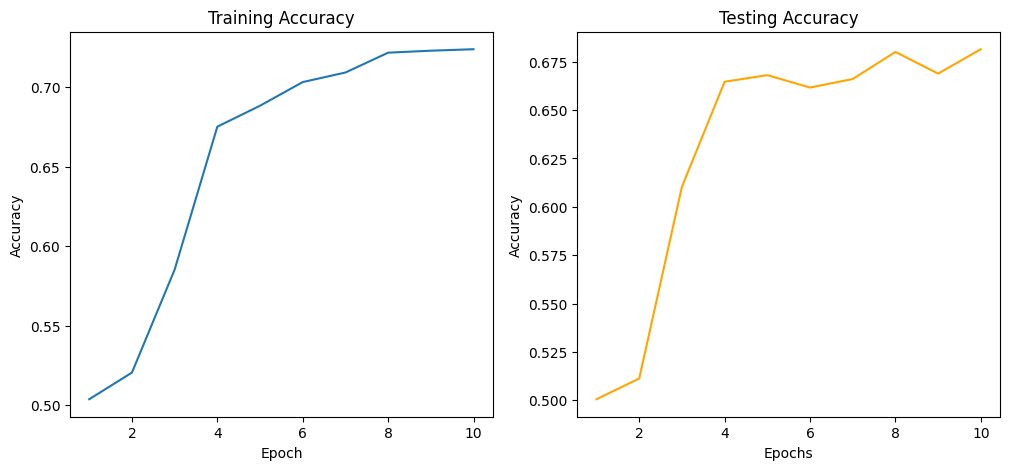

In [30]:
epochs= range(1, len(train_accuracies)+1)
plt.figure(figsize= (12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, test_accuracies,color= 'orange')
plt.title("Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [26]:
torch.save(simple_rnn_1.state_dict(), '../artifacts/parameter_tuned_rnn.pth')

In [44]:
VOCAB_SIZE= len(vocab)
EMBEDDING_DIM= 250
HIDDEN_SIZE= 512
simple_rnn_1= SimpleRNN(vocab_size= VOCAB_SIZE, embedding_dim= EMBEDDING_DIM, hidden_size= HIDDEN_SIZE)
simple_rnn_1.load_state_dict(torch.load('../artifacts/parameter_tuned_rnn.pth'))
review= 'i am a huge rachel zegler defender but i draw the line at whatever that was'
review= clean_text(review)
review= remove_stopwords(review)
tokenized_review= tokenize_text(review)
lemmatized_review= lemmatize_text(tokenized_review)

indexed_tokens= [
            vocab.get(token, 1)
            for token in lemmatized_review
        ]

if len(indexed_tokens) > max_length:
    indexed_tokens= indexed_tokens[max_length]
else:
    padding_length= max_length - len(indexed_tokens)
    padding= [0] * padding_length
    indexed_tokens= indexed_tokens + padding

index_tensor= torch.tensor(indexed_tokens, dtype= torch.long)
with torch.no_grad():
    pred= simple_rnn_1(index_tensor)
sentiment= 'negative' if pred.argmax(0) == 0 else 'positive'
sentiment, pred

('negative', tensor([ 0.3073, -0.2954]))